In [1]:
%load_ext oct2py.ipython
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform
import math
#import matplotlib.pyplot as plt
from oct2py import octave
_ = octave.addpath('/home/urban_communities/scripts') # KERDES HOL VAN?
_ = octave.addpath('/home/ubuntu/GenLouvain/')
_ = octave.addpath('/home/ubuntu/GenLouvain/private/')
from time import time
from copy import deepcopy

In [3]:
%matplotlib inline

* Ctrl + shift + - tori el a cellat
* Shift + M = merge
* az ocatve-ban a ' a transzponalas
* az octave szigoruan megkulonbozteti a sor- es oszlopvektorokat
* az octave vektor/matrix objektumai jobban hasonlitanak a np.matrix-ra mint az array-re
* az octave-ban a ./ .* stb. mindig az elemenkenti muveleteket jelentik, mintha np.array-ekkel dolgoznal
* az octave 1-tol indexel, a Python 0-tol

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


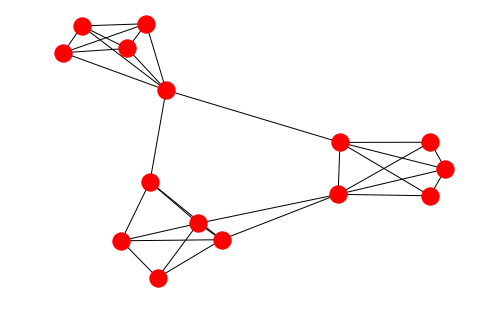

In [4]:
# Eszter graph
# a good modular input matrix
p = np.ones((3,3))*0.05 + np.eye(3)*(1-3*0.05)
G = nx.stochastic_block_model([5]*3,p) # 20 helyett 5
nx.draw(G)

In [5]:
# adjacency matrix
A = nx.adjacency_matrix(G)
# distance matrix
D = np.random.rand(len(G.nodes()),len(G.nodes()))
# importance
N = np.matrix([v for (k,v) in G.degree]).T # KERDES nem lenne jobb meghagyni vektornak, ha ugyis 1 dimenzios??
# binsize
b = 0.1

In [6]:
# TRY- modified code without loops to test code line by line

In [7]:
%%octave -i A,D,N,b -o dist,num,DeterrenceFct,normaDeterrence,matrixdistance,N,b

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

number=size(A,1); %number of nodes in the system

nbox=100; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);
matrixdistance=zeros(number,number);
nullmodelGN=zeros(number,number);
nullmodelSpa=zeros(number,number);

A=A+A'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
degree=sum(A); % degree/strength of the nodes
disp('degree')
disp(degree)
nullN=N*N'; % matrix of the importance of nodes
matrix=A./nullN; % normalised adjacency matrix

% We first calculate the correlations as a function of distance

i=number
ii=number

% convert distances in binsize's units
dist=1+ceil(D(i,ii)/b); 
matrixdistance(i,ii)=dist;

% weighted average for the deterrence function
num=matrix(i,ii);
DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1); %%%%% csak 1-től 10-ig van benne szám, 0 és 11+-ban nincs HIBA??
normaDeterrence(dist,1)=normaDeterrence(dist,1)%+N(i,1)*N(ii,1); %%%% HIBA

disp('bent')
% normalisation of the deterrence function
for i=1:nbox
    disp('bent_2')
    if(normaDeterrence(i,1)~=0)
        DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
    end
end

% copmutation of the randomised correlations (preserving space), spatial
% null-model
for i=1:number
    for ii=1:number
        nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
    end 
end

% the modularity matrix for the spatial null-model
ModularitySpa=A-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

% the modularity matrix for the GN null-model
nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
ModularityGN=A-nullmodelGN

degree

Compressed Column Sparse (rows = 1, cols = 15, nnz = 15 [100%])

  (1, 1) ->  6

  (1, 2) ->  8

  (1, 3) ->  6

  (1, 4) ->  12

  (1, 5) ->  10

  (1, 6) ->  8

  (1, 7) ->  12

  (1, 8) ->  8

  (1, 9) ->  8

  (1, 10) ->  8

  (1, 11) ->  6

  (1, 12) ->  8

  (1, 13) ->  10

  (1, 14) ->  10

  (1, 15) ->  8

i =  15

ii =  15

normaDeterrence =

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

   0

bent

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

bent_2

Oct2PyError: Octave evaluation error:
error: DeterrenceFct(0,_): subscripts must be either integers 1 to (2^31)-1 or logicals

Ide jon alulra a Python code

In [8]:
def SpaMod(A,D,N,b): # flow - adjacency matrix
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    b : float
        size of the bins in the estimation of the deterrence function
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");
    
    number=A.shape[0] # number of nodes
    nbox = 100 ## MODIFIED number of bins
    
    # intialisation of different vectors and matrices
    DeterrenceFct=np.zeros((nbox,1));
    normaDeterrence=np.zeros((nbox,1));
    matrixdistance=np.zeros((number,number));
    nullmodelGN=np.zeros((number,number));
    nullmodelSpa=np.zeros((number,number));
    
    A = A + A.T # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    
    degree = np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    nullN = N * N.T # matrix of the importance of nodes
    
    # matrix = np.divide(A.T,nullN) ## KERDESES, HOGY JO-e
    matrix = A/nullN # normalized adjacency matrix
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
    print('Preparation done.')
    
    print('Deterrence function...')

    for i in range(number):
        for ii in range(number):
            
            # convert distances in binsize's units
            dist = math.floor(D[i,ii]/b);
            matrixdistance[i,ii]=dist;

            # weighted average for the deterrence function
            num = matrix[i,ii];
            DeterrenceFct[dist,0]=DeterrenceFct[dist,0]+num*N[i,0]*N[ii,0];
            normaDeterrence[dist,0]=normaDeterrence[dist,0]+N[i,0]*N[ii,0];
    
            # ALTERNATIVELY
            # ceiler = lambda x: math.ceil(x)
            # vceil = np.vectorize(ceiler)
            # matrixdistance = vceil(D/b)
            # DeterrenceFct = DeterrenceFct + np.multiply(np.multiply(N,N.T),matrix)
            # normaDeterrence = normaDeterrence + np.multiply(N,N.T)
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
   
    print('Normalization...')
    # normalisation of the deterrence function - NINCS ELLENŐRIZVE EZ A CIKLUS
    for i in range(nbox):
        if(normaDeterrence[i,0]!=0):
            DeterrenceFct[i,0]=DeterrenceFct[i,0]/normaDeterrence[i,0];
    print('DeterrenceFct')
    print(DeterrenceFct)

    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
    
    print("Null modell...")
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    for i in range(number):
        for ii in range(number):
            nullmodelSpa[i,ii]=DeterrenceFct[matrixdistance[i,ii].astype(int),0];
    print("Done.")
    
    print("Modularity calc...")
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(nullN, nullmodelSpa*A.sum()/np.multiply(nullN,nullmodelSpa).sum());
    
    # the modularity matrix for the GN null-model
    print(type(degree))
    nullmodelGN = degree*degree/(sum(degree)); # Newman-Girvan null-model
    ModularityGN=A-nullmodelGN;
    print("Done.")
    return(ModularitySpa,ModularityGN)

In [20]:
A[0:10,0:10].todense()

matrix([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0]])

In [18]:
A.todense()

matrix([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=int64)

In [43]:
y,x = np.histogram([1,2,2,1,1,2,2,3], bins=3, range=(0.5,3.5))

In [44]:
x

array([0.5, 1.5, 2.5, 3.5])

In [45]:
y

array([3, 4, 1])

In [50]:
D.flatten().shape

(225,)

In [51]:
A.todense().flatten()

matrix([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=int64)

In [88]:
np.digitize([1.5,2.5],[1,2,3,4])

array([1, 2])

In [85]:
DeterrenceFct, detbins = np.histogram(D.flatten(), weights = np.array(A.todense()).flatten(), bins=nbox, range=(0,nbox*b))`

array([[8, 8, 8, 6, 7, 5, 6, 4, 6, 7, 7, 8, 9, 8, 5],
       [8, 7, 8, 4, 6, 9, 5, 9, 5, 8, 5, 8, 7, 6, 7],
       [5, 5, 9, 6, 7, 6, 5, 7, 5, 5, 7, 7, 5, 8, 5],
       [5, 9, 7, 5, 8, 8, 8, 4, 4, 7, 7, 5, 9, 5, 7],
       [8, 8, 4, 5, 6, 6, 5, 5, 7, 5, 5, 8, 7, 4, 8],
       [9, 8, 5, 9, 5, 5, 5, 7, 9, 9, 8, 4, 7, 9, 7],
       [5, 4, 5, 5, 9, 5, 7, 6, 4, 8, 4, 8, 8, 9, 9],
       [7, 5, 4, 8, 8, 8, 5, 5, 9, 6, 5, 4, 7, 7, 8],
       [8, 4, 4, 4, 8, 5, 8, 7, 7, 9, 8, 7, 5, 7, 9],
       [9, 5, 6, 5, 7, 7, 7, 8, 5, 8, 8, 5, 8, 9, 8],
       [8, 4, 6, 7, 9, 5, 8, 4, 6, 8, 8, 7, 7, 8, 5],
       [5, 7, 5, 7, 5, 5, 8, 6, 8, 9, 5, 5, 8, 7, 8],
       [5, 6, 9, 5, 6, 5, 7, 8, 9, 7, 7, 7, 7, 9, 7],
       [8, 8, 5, 7, 9, 5, 5, 4, 7, 5, 8, 5, 6, 5, 5],
       [8, 4, 6, 5, 4, 8, 4, 7, 5, 7, 9, 5, 8, 8, 7]], dtype=int64)

In [90]:
a = np.array([1,2])
b = np.array([[0,0],[1,1]])
a[b]

array([[1, 1],
       [2, 2]])

In [126]:
# ALTERNATIVE

def SpaMod_2(A,D,N,b): # flow - adjacency matrix
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    b : float
        size of the bins in the estimation of the deterrence function
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");   
    # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    A = (A + A.T) / 2  
        
    # deterrence function
    det, detbins = np.histogram(
        D.flatten(), 
        weights = np.array(A.todense()).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    normadet, _ = np.histogram(
        D.flatten(), 
        weights = np.array(N*N.T).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    det = det / normadet
    det[np.isnan(det)] = 0
    print('DeterrenceFct')
    
    print("Null modell...")
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    nullmodelSpa = det[np.digitize(D,detbins,right=True)-1]
    print("Done.")
    
    print("Modularity calc...")
    # the modularity matrix for the spatial null-model
    ModularitySpa = A - A.sum()*np.multiply(N*N.T,nullmodelSpa)/(np.multiply(N*N.T,nullmodelSpa).sum())
    # the modularity matrix for the GN null-model
    degree = np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    nullmodelGN = degree*degree.T/(sum(degree)) # Newman-Girvan null-model
    ModularityGN = A - nullmodelGN
    
    print("Done.")
    return ModularitySpa, ModularityGN, det

In [127]:
Ms, Mgn, Dtf = SpaMod_2(A,D,N,0.1)
S_ms,Q_ms,n_it_ms = octave.iterated_genlouvain(Ms, nout=3)
S_ms

Beginning of modularity function...
[0.01242236 0.01431981 0.00985222 0.01785714 0.0178117  0.01118568
 0.01769912 0.01796407 0.01836735 0.02232143] [0.00331425 0.10265154 0.20198882 0.3013261  0.40066339 0.50000067
 0.59933795 0.69867524 0.79801252 0.8973498  0.99668709]
DeterrenceFct
Null modell...
[[ 3  6  6  7  4  5  7  2  7  1  1  3  8  3  0]
 [ 3  4  3  2  7  8  0  8  0  2  9  3  4  7  4]
 [ 0  0  8  7  4  7  0  4  0  0  1  1  5  3  9]
 [ 0  8  0  5  3  3  6  2  2  4  1  5  8  5  1]
 [ 3  6  2  0  7  7  0  5  1  0  5  3  1  2  6]
 [ 8  6  5  8  5  0  9  1  8  8  3  2  0  8  1]
 [ 0  2  0  5  8 10  4  7  2  3  2  6  3  8  8]
 [ 4  9  2  3  3  3  5  0  8  7  9  2  4  1  6]
 [ 6  2  2  2  6  9  6  1  1  8  6  3  0  1  8]
 [ 8  5  7  0  4  1  4  6  5  6  6  9  3  8  6]
 [ 6  2  7  1  8  5  3  2  7  6  6  4  4  6  0]
 [ 5  1  0  1  5  5  6  7  3  8  9  0  3  1  6]
 [ 0  7  8  5  7  9  4  6  8  1  4  1  4  8  1]
 [ 6  3  5  4  8  9  5  2  4  9  6  5  7  0  9]
 [ 3  2  7  0  2  6  2  1 

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

# deprecated

In [44]:
np.matrix([2,1])

matrix([[2, 1]])

In [158]:
B = np.matrix([[1,2,3],[1,2,4]])
B

matrix([[1, 2, 3],
        [1, 2, 4]])

In [391]:
M_1 = np.matrix([1,2,3])
M_2 = np.matrix([4,1,2])
M_3 = np.matrix([[4,1,2],[0,0,0],[1,1,1]])
M_3

matrix([[4, 1, 2],
        [0, 0, 0],
        [1, 1, 1]])

In [397]:
W = np.multiply(M_1.T,M_1)
W

matrix([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [395]:
np.multiply(np.multiply(M_1.T,M_1),M_3)

matrix([[4, 2, 6],
        [0, 0, 0],
        [3, 6, 9]])

In [308]:
SUM=B.sum(axis=0)
SUM

matrix([[100,   4,   7]])

In [315]:
F = np.asarray(SUM)
F_2 = np.squeeze(F)
F_2[0]

100

In [53]:
B.sum()

13

In [368]:
B

matrix([[99,  2,  3],
        [ 1,  2,  4]])

In [370]:
C

matrix([[1.    , 3.    , 6.    ],
        [1.5998, 3.2237, 2.162 ]])

In [390]:
np.multiply(B,C)

matrix([[0.    , 6.    , 0.    ],
        [1.5998, 6.4474, 8.648 ]])

In [59]:
B-C

matrix([[ 0. , -1. , -3. ],
        [ 0.5,  1.8,  3.9]])

In [356]:
b

0.1

In [389]:
C = np.matrix([[0,3,0],[1.5998,3.2237,2.162]])
C

matrix([[0.    , 3.    , 0.    ],
        [1.5998, 3.2237, 2.162 ]])

3

In [ ]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N


% Flow,Dist,N,binsize - kellenek valami pofonegyszeru bemeneti adatok!

disp("Beginning of modularity function...");

number=size(Flow,1); %number of nodes in the system

nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);
matrixdistance=zeros(number,number);
nullmodelGN=zeros(number,number);
nullmodelSpa=zeros(number,number);
Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
degree=sum(Flow); % degree/strength of the nodes
nullN=N*N'; % matrix of the importance of nodes
matrix=Flow./nullN; % normalised adjacency matrix

disp("Preparation done.")

disp("Deterrence function...")

%We first calculate the correlations as a function of distance

KERDES
for i=1:number
    disp(i)
    for ii=1:number
    
    % convert distances in binsize's units
    dist=1+ceil(Dist(i,ii)/binsize); 
    matrixdistance(i,ii)=dist;

    % weighted average for the deterrence function
    num=matrix(i,ii);
    DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
    normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
    end
    disp("Done.")
disp("Normalization...")
% normalisation of the deterrence function
for i=1:nbox
    disp(i)
    if(normaDeterrence(i,1)~=0)
        DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
    end
end

disp("Done.")

disp("Null modell...")

% copmutation of the randomised correlations (preserving space), spatial
% null-model
for i=1:number
    for ii=1:number
        nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
    end 
end

disp("Done.")

disp("Modularity calc...")
% the modularity matrix for the spatial null-model
ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

% the modularity matrix for the GN null-model
nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
ModularityGN=Flow-nullmodelGN;
disp("Done.")

In [131]:
%%octave -i A,D,N,b -o number,DeterrenceFct,normaDeterrence,matrixdistance,nullmodelGN,nullmodelSpa

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [number,DeterrenceFct,normaDeterrence,matrixdistance,nullmodelGN,nullmodelSpa]=ModularitySpaGN(A,Dist,N,binsize)

    % Flow: Adjacency matrix REPLACE --> A
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    disp(size(A,1))
    number=size(A,1); %number of nodes in the system
    

    nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    normaDeterrence=zeros(nbox,1);

    matrixdistance=zeros(number,number);
    nullmodelGN=zeros(number,number);
    nullmodelSpa=zeros(number,number);
endfunction

In [ ]:
    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix

    %We first calculate the correlations as a function of distance

    for i=1:number
        for ii=1:number

        % convert distances in binsize's units
        dist=1+ceil(Dist(i,ii)/binsize); 
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix(i,ii);
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end

    % normalisation of the deterrence function
    for i=1:nbox
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Mg);

In [ ]:
%%octave -i A,D,N,b -o number, normaDeterrence

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

number=size(A,1); %number of nodes in the system

nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);

In [ ]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [ModularitySpa,ModularityGN,DeterrenceFct]=ModularitySpaGN(Flow,Dist,N,binsize)

    % Flow: Adjacency matrix
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    number=size(Flow,1); %number of nodes in the system
    disp('number:')
    disp(number)

    nbox=100; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    % disp('DeterrenceFct')
    % disp(DeterrenceFct)
    normaDeterrence=zeros(nbox,1);
    % disp('normaDeterrence')
    % disp(normaDeterrence)

    matrixdistance=zeros(number,number);
    % disp('matrixdistance')
    % disp(matrixdistance)
    nullmodelGN=zeros(number,number);
    % disp('nullmodelGN')
    % disp(nullmodelGN)
    nullmodelSpa=zeros(number,number);
    % disp('nullmodelSpa')
    % disp(nullmodelSpa)

    % INNEN NEM MEGY!!!
    disp(Flow)
    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    disp('Flow')
    disp(Flow)

   
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix

    %We first calculate the correlations as a function of distance

    for i=1:number
        for ii=1:number

        % convert distances in binsize's units
        dist=1+% ceil(Dist(i,ii)/binsize); 
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix[i][ii];
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end

    % normalisation of the deterrence function
    for i=1:nbox
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Mg);